In [2]:
import sys
import subprocess
import numpy as np
import pandas as pd
import scipy.io as sio

import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np
from core import *



In [3]:
data_folder='/home/ofir/Bcells/GitHub/Bit/Data/'

In [4]:
table_a= pd.DataFrame(columns=['clone','table'])


In [5]:
for i in range (1,21):
    table_a=table_a.append({'clone':data_folder+'clone_dataMS2_vv'+str(i)+'.csv','table': data_folder+'sim_dataMS2_vv'+str(i)+'.csv'  }, ignore_index=True)

In [6]:
table_summary= pd.DataFrame(columns=['Data','sen_short','sen_mid','sen_long','spec_short','spec_mid','spec_long','ppv_short','ppv_mid','ppv_long'])

In [7]:

W_l_vec=np.arange(100,200,10)
table_summary_length= pd.DataFrame(columns=['Length','sen_s','spec_s','ppv_s'])

In [8]:
def truncate_sequence_v(table,W_l=200,E_l=0):
    import pandas as pd
    table_last= pd.DataFrame(columns=['end'])
    sequencesplit=[]
    M=table.shape[0]
    
   # W_l=200
    
    for i in range (0,M):
        s_l=table[i].__len__()
        table_last = table_last.append({'end': table[i][s_l-W_l:s_l-E_l]}, ignore_index=True)
    return table_last

In [ ]:
sen_arr=[]
spec_arr=[]
ppv_arr=[]

sen_vec_strickt=[]
spec_vec_strickt=[]
ppv_vec_strickt=[]

for i in range(0,20):

    table_clone=pd.read_csv(table_a.clone[i])
    table=pd.read_csv(table_a.table[i])

    clone_list=table_clone.SEED_SEQUENCE_ID[:]

    table_short=table.SEQUENCE[:]

    
    
    M=table.shape[0]



    labels_list,cloned_list_full_f=clone_inference(clone_list,clone_list)
    
    for W_l in np.arange(100,200,10):
        sen_vec=[]
        spec_vec=[]
        ppv_vec=[]
        for k in np.arange(2,10):


            table_last=truncate_sequence_v(table_short,W_l,0)
            def ngrams(string,n=k):
                string = re.sub(r'[,-./]|\sBD',r'', string)
                ngrams = zip(*[string[i:] for i in range(n)])
                return [''.join(ngram) for ngram in ngrams]

            vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams,use_idf=True)
            tf_idf_matrix_full= vectorizer.fit_transform(table_last.end)
            matches_fast_s= awesome_cossim_top(tf_idf_matrix_full[:], tf_idf_matrix_full[:].transpose(), 1900, 0.1)
            dist2nearestcosine=compute_dist2nearest(matches_fast_s)
            thresh_cosine_o=np.percentile(dist2nearestcosine[labels_list==0], 1)



            clusters_cosine_full_s=cluster_from_matches(matches_fast_s,thresh_cosine_o)
            labels_list,cloned_list_full_s=clone_inference(clone_list,clusters_cosine_full_s)

            sensitivity_s=sum(cloned_list_full_s[np.where(labels_list==1)]==1)/sum(labels_list==1)
            print('sen=',sensitivity_s)
            specificity_s=sum(cloned_list_full_s[np.where(labels_list==0)]==0)/sum(labels_list==0)
            print('specificity=',specificity_s)
            ppv_s=sum(labels_list[np.where(cloned_list_full_s==1)]==1)/sum(cloned_list_full_s==1)
            print('PPV=',ppv_s)
            sen_vec=np.append(sen_vec,sensitivity_s)
            spec_vec=np.append(spec_vec,specificity_s)
            ppv_vec=np.append(ppv_vec,ppv_s)


            if 0:
                sensitivity_s=sensitivity_comp(clone_list,clusters_cosine_full_s)  
                print('sen=',sensitivity_s)
                specificity_s=specificity_comp(clone_list,clusters_cosine_full_s,100) 
                print('specificity=',specificity_s)
                ppv_s=PPV_comp(clone_list,clusters_cosine_full_s) 
                print('PPV=',ppv_s)
                sen_vec_strickt=np.append(sen_vec_strickt,sensitivity_s)
                spec_vec_strickt=np.append(spec_vec_strickt,specificity_s)
                ppv_vec_strickt=np.append(ppv_vec_strickt,ppv_s)


        sen_arr.append(sen_vec)
        spec_arr.append(spec_vec)
        ppv_arr.append(ppv_vec)

sen= 0.8017683566185847
specificity= 0.9899716847569608
PPV= 0.9970046164147021
sen= 0.9000481763822371
specificity= 0.9902076451156205
PPV= 0.9973934616713249
sen= 0.9197721540510669
specificity= 0.9902076451156205
PPV= 0.9974492147884078
sen= 0.9465525547652109
specificity= 0.9899716847569608
PPV= 0.9974616257540465
sen= 0.9557344064386318
specificity= 0.9899716847569608
PPV= 0.9974859509021
sen= 0.9602969932269675
specificity= 0.9899716847569608
PPV= 0.9974978658267346
sen= 0.9596735341627228
specificity= 0.9902076451156205
PPV= 0.9975550122249389
sen= 0.9605237056139655
specificity= 0.9903256252949505
PPV= 0.9975865316694137
sen= 0.8254314620115056
specificity= 0.9899716847569608
PPV= 0.9970902368889497
sen= 0.9574347493411172
specificity= 0.9900896649362907
PPV= 0.9975198559154389
sen= 0.9670133476917845
specificity= 0.9900896649362907
PPV= 0.9975443622650335
sen= 0.9788307308640576
specificity= 0.9900896649362907
PPV= 0.9975739371534196
sen= 0.983648369087766
specificity= 0.98997

In [17]:
sen_mat=sen_vec_strickt
spec_mat=spec_vec_strickt
ppv_mat=ppv_vec_strickt

In [18]:
sen_mat=np.array(sen_arr).reshape(-1)
spec_mat=np.array(spec_arr).reshape(-1)
ppv_mat=np.array(ppv_arr).reshape(-1)

In [19]:
def plot_mean_and_CI(x_vec,mean, lb, ub, color_mean=None, color_shading=None,name1='b'):
   # plt.set_facecolor('w')
    # plot the shaded range of the confidence intervals
    plt.style.use('_classic_test')
    plt.grid(None)
    plt.fill_between(x_vec, ub, lb,
                     color=color_shading, alpha=.3)
    
    # plot the mean on top
    plt.plot(x_vec,mean, color_mean,label=name1,linewidth=10)

In [21]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",**cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1])+.5)
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

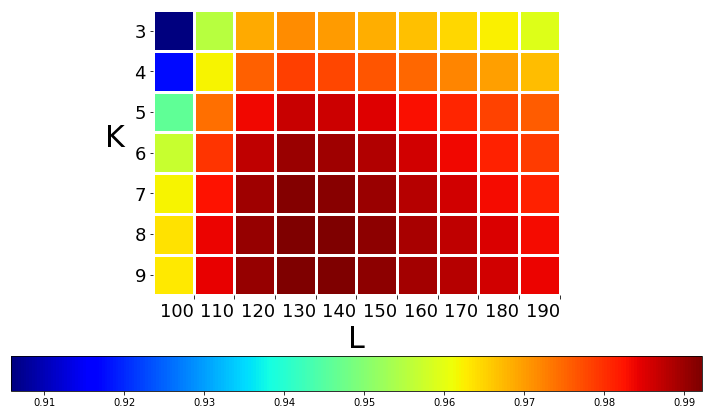

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

im, cbar = heatmap(np.mean(np.array(sen_arr).reshape(20,-1,8),axis=0).T[1:,:], np.arange(3,10), np.arange(100,200,10), ax=ax,
                   cmap="jet")
#cbar.set_label('Sensitivity',size=30)
#cbar.set_ticklabels(20)
#cbar.ax.tick_params(labelsize=20,pad=2)
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
plt.tick_params(labelsize=18)
plt.xlabel('L',size=30)
plt.ylabel('K',size=30,rotation=0,labelpad=20)
fig.tight_layout()

